In [1]:

from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import torch.nn.functional as F
import functools
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import time

import Augmentor

from torchsummary import summary

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
# Training settings
batch_size = 50

In [70]:
#%%

# p = Augmentor.Pipeline()
# p.random_erasing(0.5,0.4)




train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop((32, 32), padding=4),   #left, top, right, bottom
#     p.torch_transform(),
#     p.sample(10000),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/lee/Research/11.project_tangqing/data',
                               train=True,
                               transform=train_transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='/home/lee/Research/11.project_tangqing/data',
                              train=False,
                              transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, # 64
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

dataloaders = {
    'train': train_loader,
    'test' : test_loader    
}
image_datasets = {
    'train': train_dataset,
    'test' : test_dataset
}
dataset_sizes = {
    'train': len(image_datasets['train']),
    'test' : len(image_datasets['test'])
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print('train_size: ',dataset_sizes['train'],'\ntest_size : ',dataset_sizes['test'])
print(classes)
print('len class: ', len(classes))



Files already downloaded and verified
train_size:  50000 
test_size :  10000
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
len class:  10


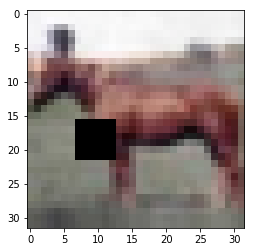

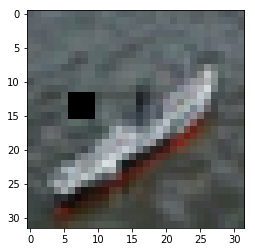

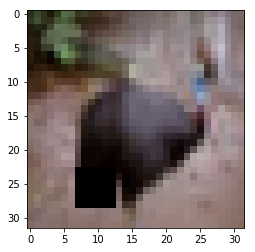

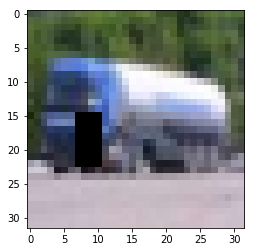

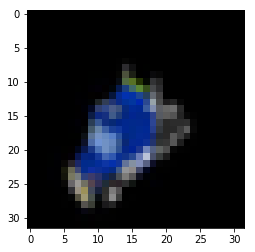

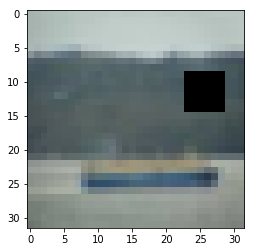

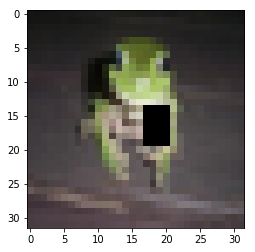

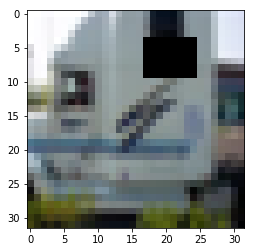

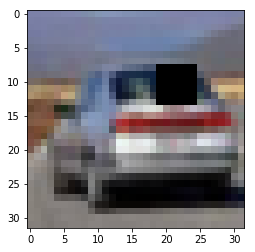

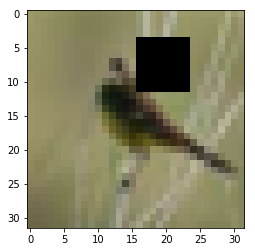

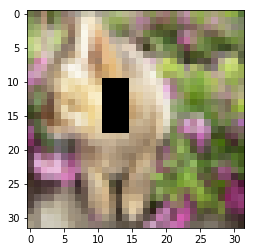

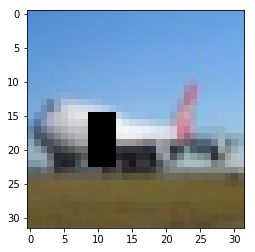

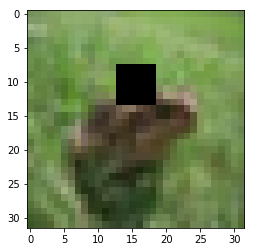

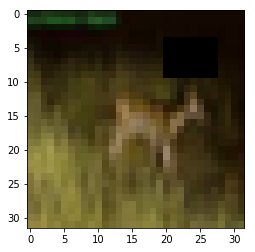

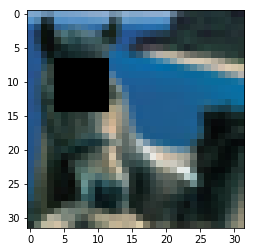

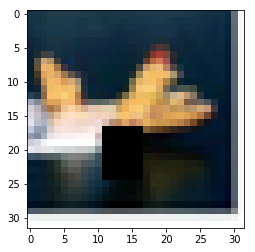

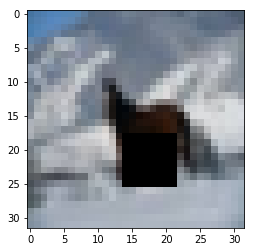

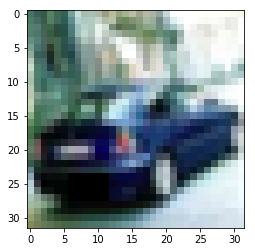

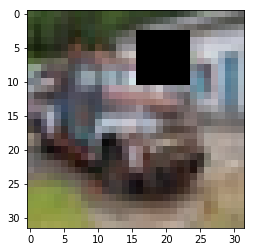

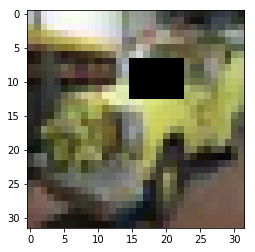

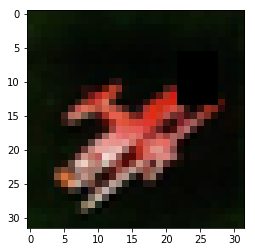

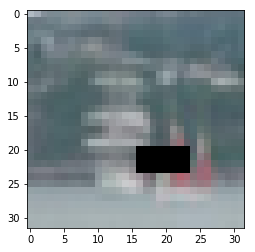

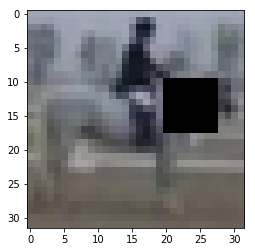

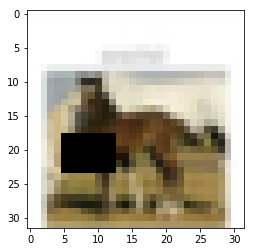

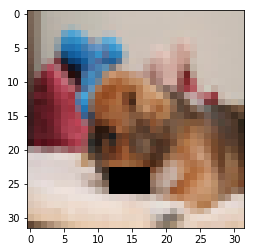

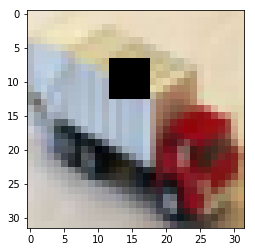

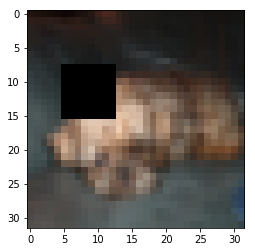

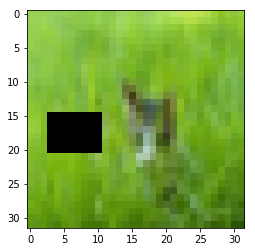

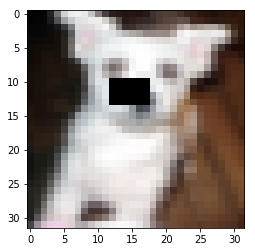

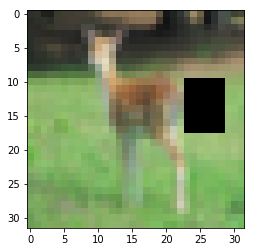

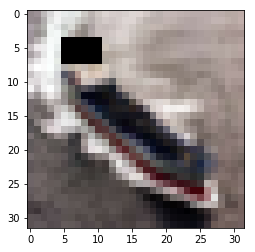

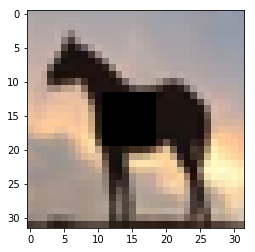

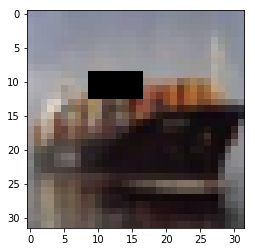

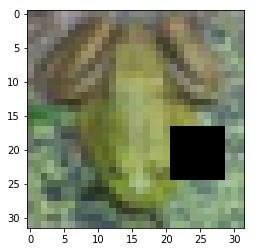

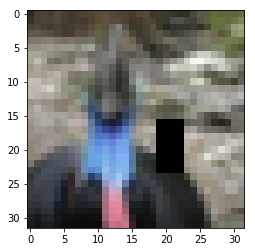

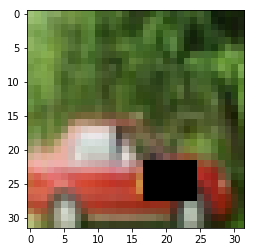

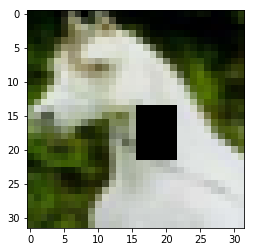

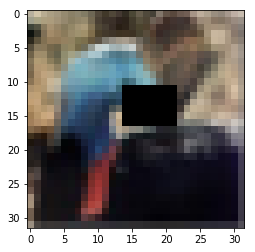

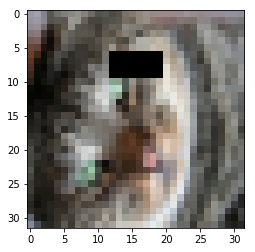

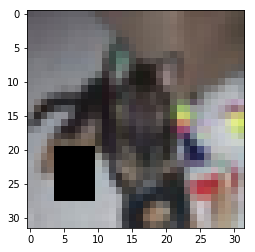

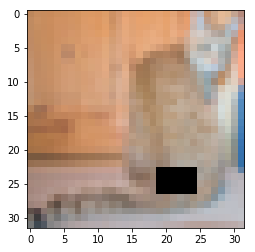

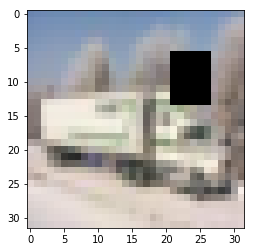

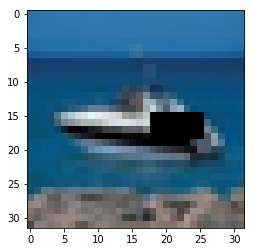

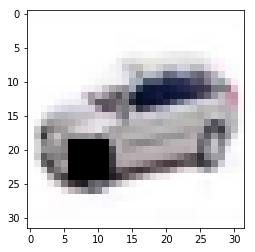

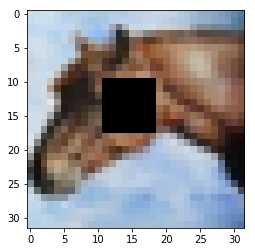

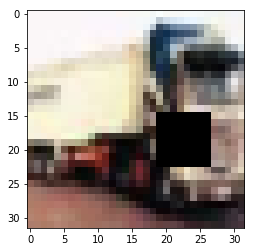

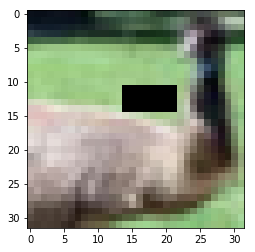

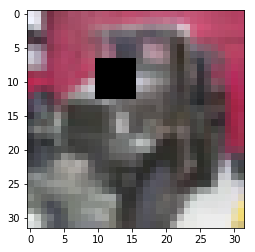

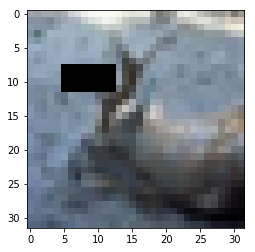

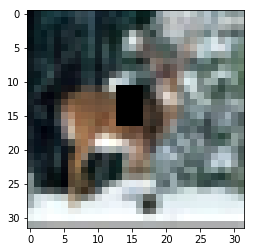

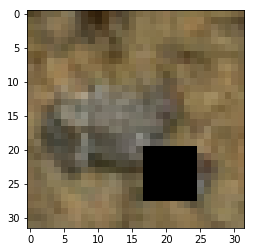

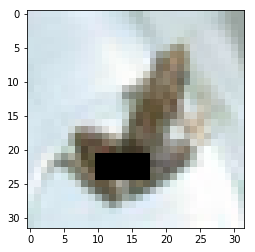

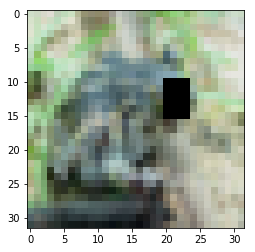

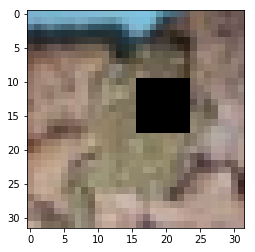

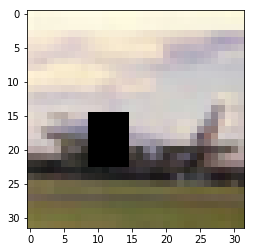

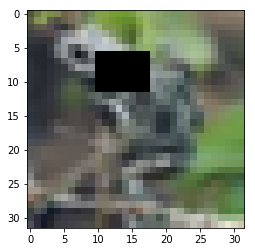

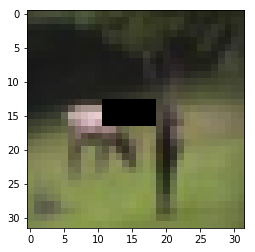

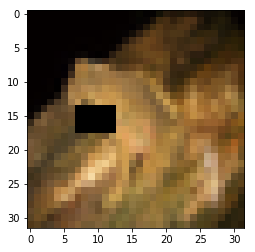

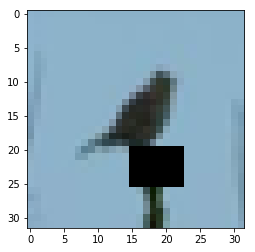

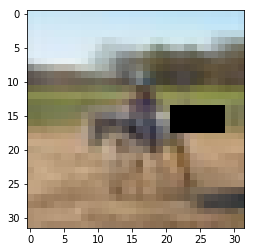

KeyboardInterrupt: 

In [82]:
import cv2
# # ADDING NOISE
noise = np.random.randint(0,1, size = (32, 32,3), dtype = 'uint8')
# print(noise)
for n in range(1000):
    inputs, labels = next(iter(dataloaders['train']))
    for m in range(batch_size):
        images_ = inputs[m].numpy()
        class_  = labels[m]
        images_ = np.transpose(images_, [1,2,0])
        x_random = np.random.randint(6, 27, size=1, dtype='uint8')
        y_random = np.random.randint(6, 27, size=1, dtype='uint8')
        w_random = np.random.randint(5, 10, size=1, dtype='uint8')
        h_random = np.random.randint(5, 10, size=1, dtype='uint8')
        images_[y_random[0]-int(h_random[0]/2):y_random[0]+int(h_random[0]/2),x_random[0]-int(w_random[0]/2):x_random[0]+int(w_random[0]/2),:]=noise[y_random[0]-int(h_random[0]/2):y_random[0]+int(h_random[0]/2),x_random[0]-int(w_random[0]/2):x_random[0]+int(w_random[0]/2),:]
#         print(images_)
        print(classes[class_.numpy()])
        cv2.imwrite('/home/lee/Research/11.project_tangqing/data/cifar-10-occulde/{}_{}.jpg'.format(classes[class_.numpy()],n*m+m),images_)
        plt.imshow(images_)
        plt.show()


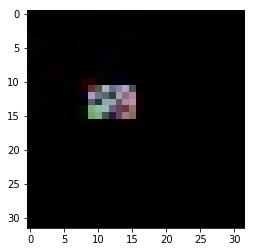

Traceback (most recent call last):
  File "/home/lee/anaconda3/envs/pytorch1/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/lee/anaconda3/envs/pytorch1/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/lee/anaconda3/envs/pytorch1/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/lee/anaconda3/envs/pytorch1/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


In [75]:
img11=cv2.imread('/home/lee/Research/11.project_tangqing/data/cifar-10-occulde/bird.jpg')
plt.imshow(img11)
plt.show()